In [1]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

/home/nuk/anaconda3/envs/DeepLearning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EPOCHS = 5
data_dir = "rsna-pneumonia-detection-challenge/"
TEST = 'stage_2_test_images_preprocessed_hires_jpg'
TRAIN = 'stage_2_train_images_preprocessed_hires_jpg'
VAL ='stage_2_val_images_preprocessed_hires_jpg'

In [3]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485], [0.229]),
        ])
        
    if phase == VAL:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485], [0.229]),
        ])
    
    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485], [0.229]),
        ])        
        
    return transform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x)) 
                  for x in [TRAIN, VAL, TEST]}

dataloaders = {TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 32, shuffle=True), 
               VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 1, shuffle=True), 
               TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)}

In [5]:
len(dataloaders[TRAIN])

338

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL]}
classes = image_datasets[TRAIN].classes
class_names = image_datasets[TRAIN].classes

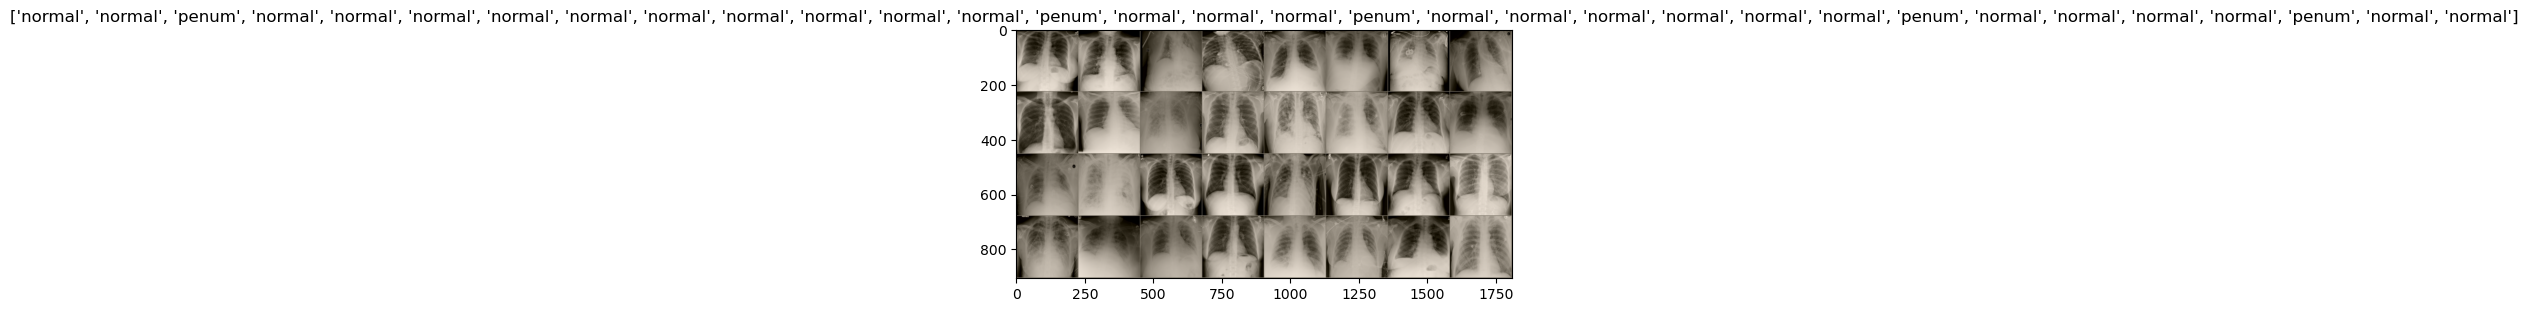

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


inputs, classes = next(iter(dataloaders[TRAIN]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [8]:
inputs, classes = next(iter(dataloaders[TRAIN]))

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    training_loss_plotting = np.zeros(num_epochs)
    validation_loss_plotting = np.zeros(num_epochs)
    training_acc_plotting = np.zeros(num_epochs)
    validation_acc_plotting = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)
        
        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == TRAIN:
                training_loss_plotting[epoch] = epoch_loss
                training_acc_plotting = epoch_acc

            elif phase == VAL:
                validation_loss_plotting[epoch] = epoch_loss
                validation_acc_plotting[epoch] = epoch_acc


    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

    np.save("train_loss_epoch.npy", training_loss_plotting)
    np.save("val_loss_epoch.npy", validation_loss_plotting)
    np.save("train_acc_epoch.npy", training_acc_plotting)
    np.save("val_acc_epoch.npy", validation_acc_plotting)
    
    return model

In [12]:
model_pre = models.vgg16()
model_pre.load_state_dict(torch.load("vgg16-397923af.pth"))

<All keys matched successfully>

In [13]:
for param in model_pre.features.parameters():
    param.required_grad = False

num_features = model_pre.classifier[6].in_features
features = list(model_pre.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, len(class_names))])
model_pre.classifier = nn.Sequential(*features) 
print(model_pre)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [15]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch: 1/5


/home/nuk/anaconda3/envs/DeepLearning/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


stage_2_train_images_preprocessed_hires_jpg Loss: 0.6423 Acc: 0.6298
stage_2_val_images_preprocessed_hires_jpg Loss: 0.5714 Acc: 0.8116
Epoch: 2/5
stage_2_train_images_preprocessed_hires_jpg Loss: 0.6478 Acc: 0.6267
stage_2_val_images_preprocessed_hires_jpg Loss: 0.5714 Acc: 0.8116
Epoch: 3/5
stage_2_train_images_preprocessed_hires_jpg Loss: 0.6425 Acc: 0.6308
stage_2_val_images_preprocessed_hires_jpg Loss: 0.5714 Acc: 0.8116
Epoch: 4/5
stage_2_train_images_preprocessed_hires_jpg Loss: 0.6416 Acc: 0.6252
stage_2_val_images_preprocessed_hires_jpg Loss: 0.5714 Acc: 0.8116
Epoch: 5/5
stage_2_train_images_preprocessed_hires_jpg Loss: 0.6448 Acc: 0.6236
stage_2_val_images_preprocessed_hires_jpg Loss: 0.5714 Acc: 0.8116
Best val Acc: 0.000000


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [16]:
torch.save({
    'model_state_dict': model_pre.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # You can include other elements as needed (e.g., epoch, loss history, etc.)
}, 'CNN_transfer_learning.pth')

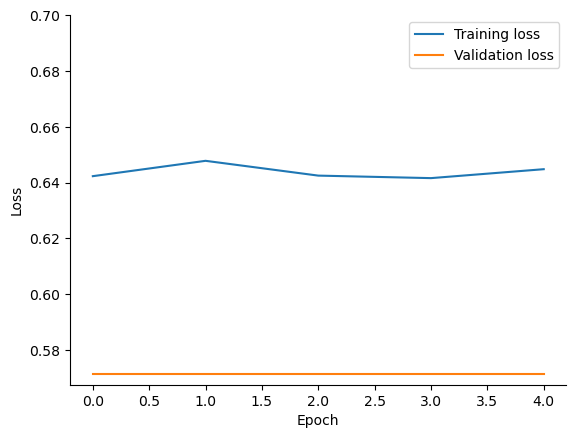

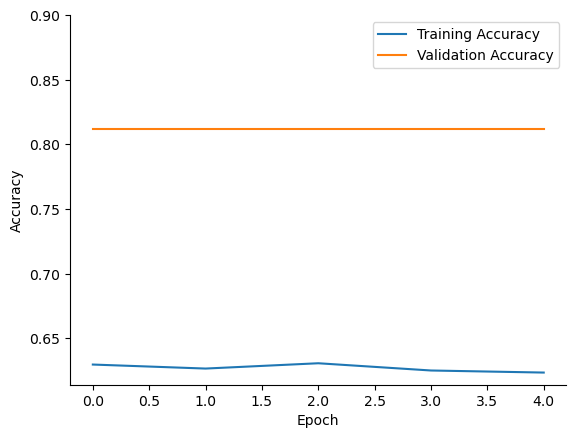

In [37]:
training_loss = np.array([0.6423, 0.6478, 0.6425, 0.6416, 0.6448])
validation_loss = np.array([0.5714, 0.5714, 0.5714, 0.5714, 0.5714])
training_acc = np.array([0.6298, 0.6267, 0.6308, 0.6252, 0.6236])
validation_acc = np.array([0.8116, 0.8116, 0.8116, 0.8116, 0.8116])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(training_loss, label = "Training loss")
ax.plot(validation_loss, label = "Validation loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.set_ylim([None, 0.7])
plt.legend()
sns.despine()

plt.savefig("Loss_CNN.png", dpi = 600)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(training_acc, label = "Training Accuracy")
ax.plot(validation_acc, label = "Validation Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")

ax.set_ylim([None, 0.9])
plt.legend()
sns.despine()

plt.savefig("Accuracy_CNN.png", dpi = 600)

In [20]:
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
        acc = running_correct/running_total
    return (true_labels, pred_labels, running_correct, running_total, acc)

In [21]:
true_labels, pred_labels, running_correct, running_total, acc = test_model()

In [22]:
print("Total Correct: {}, Total Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

Total Correct: 4047.0, Total Test Images: 5334.0
Test Accuracy:  0.7587176602924635


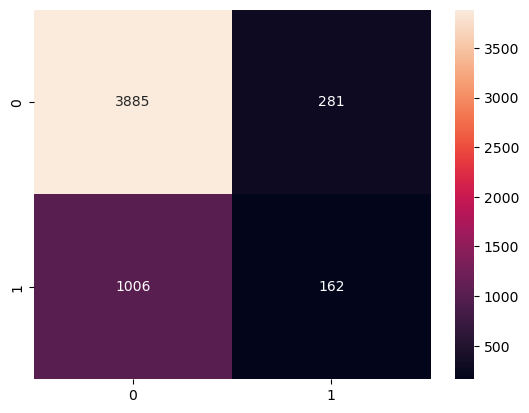

In [27]:
cm = confusion_matrix(true_labels, pred_labels)
tn, fp, fn, tp = cm.ravel()
ax = sns.heatmap(cm, annot=True, fmt="d")
plt.savefig("heatmap_cnn.png", dpi = 600)

In [26]:
plt.savefig("heatmap_backup.png", dpi = 1200)

<Figure size 640x480 with 0 Axes>

In [19]:
# Plot the training

foo = np.load("test_acc_epoch.npy")
print(foo)

FileNotFoundError: [Errno 2] No such file or directory: 'test_acc_epoch.npy'